In [1]:
%load_ext autoreload
%autoreload 2
import pandas as pd
import scanpy as sc
import anndata
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap

In [2]:
adata_rna = sc.read_h5ad('/hpc/mydata/siyu.he/coral_storage/Data_SpatialGlue/Dataset13_Simulation1/adata_RNA.h5ad')
adata_adt = sc.read_h5ad('/hpc/mydata/siyu.he/coral_storage/Data_SpatialGlue/Dataset13_Simulation1/adata_ADT.h5ad')

In [3]:
def downsample_spatial_data(adata, norm_spatial, original_spatial, block_size=3):
    n_blocks = 12
    block_data = []
    block_spatial = []
    
    for i in range(n_blocks):
        for j in range(n_blocks):
        
            min_x, max_x = i / n_blocks, (i + 1) / n_blocks
            min_y, max_y = j / n_blocks, (j + 1) / n_blocks
            
            
            block_indices = np.where(
                (norm_spatial[:, 0] >= min_x) & (norm_spatial[:, 0] <= max_x) &
                (norm_spatial[:, 1] >= min_y) & (norm_spatial[:, 1] <= max_y)
            )[0]
            
            if len(block_indices) > 0:
                block_data.append(adata.X[block_indices].sum(axis=0))
                block_spatial.append(original_spatial[block_indices].mean(axis=0))
    
    return np.array(block_data), np.array(block_spatial)

adata = adata_rna.copy() #adata_smoothed.copy()#
spatial_data = adata.obsm['spatial']
min_coord = spatial_data.min(axis=0)
max_coord = spatial_data.max(axis=0)
norm_spatial = (spatial_data - min_coord) / (max_coord - min_coord)

new_data, new_spatial = downsample_spatial_data(adata, norm_spatial, spatial_data)

# Create a new AnnData object for the downsampled data
adata_downsampled = sc.AnnData(X=new_data)
adata_downsampled.obsm['spatial'] = new_spatial

# Preprocess the downsampled data (e.g., normalization, PCA)
sc.pp.normalize_total(adata_downsampled, target_sum=1e4)
sc.pp.log1p(adata_downsampled)
sc.tl.pca(adata_downsampled, svd_solver='arpack')

# Compute the neighborhood graph
sc.pp.neighbors(adata_downsampled, n_neighbors=10, n_pcs=50)


Text(0, 0.5, '')

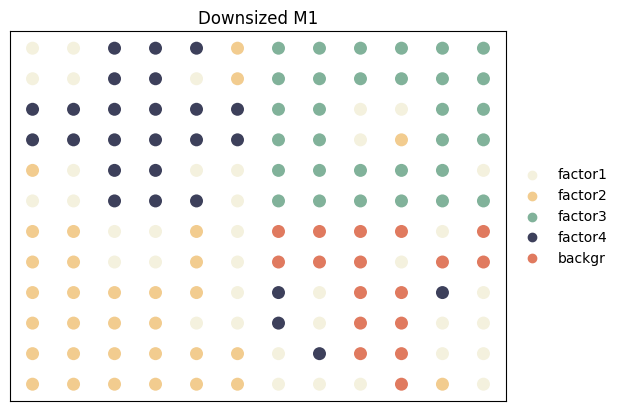

In [5]:
# Perform Leiden clustering with adjusted resolution for fewer clusters
sc.tl.leiden(adata_downsampled, resolution=0.6)
annotation_mapping = {
    '0': 'factor1',
    '1': 'factor2',
    '2': 'factor3',
    '3': 'factor4',
    '4': 'backgr'  
}
list_ = ['factor1','factor2','factor3','factor4','backgr']

adata_downsampled.obs['cluster'] = adata_downsampled.obs['leiden'].map(annotation_mapping)
adata_downsampled.obs['cluster']  = pd.Categorical(adata_downsampled.obs['cluster'], 
                      categories=list_,
                      ordered=True)
adata_downsampled.obs['gene'] = adata_downsampled.to_df().iloc[:,0]

custom_palette = ['#f4f1de', '#f2cc8f', '#81b29a', '#3d405b', '#e07a5f']

sc.pl.embedding(adata_downsampled, basis='spatial', title='Downsized M1', color='cluster', s=350, show=False,palette=custom_palette)
plt.xlabel('')
plt.ylabel('')

In [29]:
adata_adt

AnnData object with n_obs × n_vars = 1296 × 100
    uns: 'log1p'
    obsm: 'nsfac', 'spatial', 'spfac'
    varm: 'nsload', 'spload'
    layers: 'counts'

In [30]:
adata_downsampled.write('/hpc/mydata/siyu.he/coral_storage/simulation_data/data1/UMI/sp_adata.h5ad')

sc.pp.pca(adata_adt)
sc.pp.neighbors(adata_adt,n_neighbors=30)
sc.tl.leiden(adata_adt,resolution=0.06)
adata_adt.obs['subclass'] = adata_adt.obs['leiden']

adata_adt.write('/hpc/mydata/siyu.he/coral_storage/simulation_data/data1/merfish_data.h5ad')


In [19]:
sc.read_h5ad('/hpc/mydata/siyu.he/coral_storage/spatial_scope_data/simulate_01/merfish_data.h5ad')

AnnData object with n_obs × n_vars = 940 × 254
    obs: 'sample_id', 'slice_id', 'class_label', 'subclass', 'label', 'X', 'Y', 'n_counts', 'cell_type'
    var: 'n_cells'
    uns: 'log1p', 'neighbors', 'pca', 'subclass_colors', 'umap'
    obsm: 'X_pca', 'X_umap'
    varm: 'PCs'
    obsp: 'connectivities', 'distances'

In [27]:
sc.read_h5ad('/hpc/mydata/siyu.he/HCC_project/SpatialScope/output/57/UMI/sp_adata.h5ad').obs


,x,y,cell_nums
spot_0,-5494.036077,3385.059665,1
spot_1,-5494.036077,3503.348762,2
spot_2,-5494.036077,3532.921037,2
spot_3,-5494.036077,3562.493311,1
spot_4,-5494.036077,3592.065585,1
...,...,...,...
spot_595,-5019.046243,4893.245657,3
spot_596,-5019.046243,4922.817931,2
spot_597,-5019.046243,4952.390206,2
spot_598,-5019.046243,4981.962480,5


In [31]:
!python ../SpatialScope/src/Decomposition.py \
--tissue $'UMI' \
--out_dir /hpc/mydata/siyu.he/coral_storage/simulation_data/data1 \
--SC_Data /hpc/mydata/siyu.he/coral_storage/simulation_data/data1/merfish_data.h5ad \
--cell_class_column subclass \
--ckpt_path /hpc/mydata/siyu.he/HCC_project/SpatialScope/dataset/model_06500.pt \
--replicates 5 \
--gpu 0 \



2024-08-07 17:38:12,695 : INFO : load scRNA-seq reference: /hpc/mydata/siyu.he/coral_storage/simulation_data/data1/merfish_data.h5ad
2024-08-07 17:38:12,727 : INFO : scRNA-seq reference Maximum value: 623.0, need to run log1p
2024-08-07 17:38:12,731 : INFO : scRNA-seq reference data shape: (1296, 100)
2024-08-07 17:38:12,731 : INFO : scRNA-seq reference cell class number: 11
2024-08-07 17:38:12,732 : INFO : load checkpoint: /hpc/mydata/siyu.he/HCC_project/SpatialScope/dataset/model_06500.pt
2024-08-07 17:38:12,765 : ERROR : Wrong checkpoints/scRef file, checkpoint gene number: 254, scRef marker genes number: 100


In [33]:
import scvi
scvi.model.TOTALVI

scvi.model._totalvi.TOTALVI

In [20]:
!pip install ray

Defaulting to user installation because normal site-packages is not writeable
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 64.9/64.9 MB 47.9 MB/s eta 0:00:0000:0100:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 309.3/309.3 kB 25.8 MB/s eta 0:00:00
